# Cyberbullying classification

goal: Classifiy whether the text is considered 6 different classes of cyber bullying or not

data taken from https://www.kaggle.com/andrewmvd/cyberbullying-classification

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


In [2]:
df = pd.read_csv("cyberbullying_tweets.csv")
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


1 means the text is not considered cyber bullying. 
0 means the text is not considered cyber bullying

In [3]:
df["cyberbullying_type"] = df["cyberbullying_type"].replace(["religion", "age", "gender", "ethnicity", "other_cyberbullying"], 1)
df["cyberbullying_type"] = df["cyberbullying_type"].replace(["not_cyberbullying"], 0)
df["cyberbullying_type"].value_counts()

1    39747
0     7945
Name: cyberbullying_type, dtype: int64

In [4]:
train, test = train_test_split(df, test_size=0.2)

train_examples, train_labels = train["tweet_text"], train["cyberbullying_type"]
test_examples, text_labels = test["tweet_text"], test["cyberbullying_type"]

In [5]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 38153, test entries: 9539


In [6]:
model = "https://tfhub.dev/google/nnlm-en-dim128/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 128), dtype=float32, numpy=
array([[ 1.00577228e-01,  9.50349774e-03, -5.09516941e-03,
         5.11213392e-02,  2.07470298e-01, -1.31973242e-02,
         2.48375759e-02, -5.72604723e-02, -1.39509752e-01,
         4.69083413e-02, -8.13105628e-02, -1.82630762e-01,
         6.65813237e-02, -4.66223508e-02,  8.43232572e-02,
         1.62773147e-01,  3.18724401e-02, -1.61198258e-01,
        -4.01418731e-02,  1.74440116e-01, -7.86616281e-02,
        -1.33894458e-01,  6.60317810e-03,  8.31400380e-02,
         3.69181484e-02, -1.66967183e-01,  2.91453023e-02,
         5.16837649e-02, -1.58890501e-01, -7.04898089e-02,
        -3.96677367e-02,  3.66322473e-02, -7.60932863e-02,
         1.76979050e-01,  1.63362235e-01, -3.85591835e-02,
        -1.14648439e-01,  1.02881812e-01,  1.57736495e-01,
         1.23382293e-01, -1.98601767e-01, -1.49433345e-01,
        -1.13713987e-01, -1.90862149e-01,  1.40056238e-01,
         1.08100362e-01,  2.82695815e-02, -2.61435807e-02,
      

In [7]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=False),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [9]:
history = model.fit(train_examples,
                    train_labels,
                    epochs=40,
                    batch_size=512,
                    validation_data=(test_examples, text_labels),
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])


Epoch 1/40
75/75 [==============================] - 81s 1s/step - loss: 1.1686 - accuracy: 0.8040 - val_loss: 0.3882 - val_accuracy: 0.8404
Epoch 2/40
75/75 [==============================] - 76s 1s/step - loss: 0.3248 - accuracy: 0.8385 - val_loss: 0.3764 - val_accuracy: 0.8424
Epoch 3/40
75/75 [==============================] - 78s 1s/step - loss: 0.2612 - accuracy: 0.8428 - val_loss: 0.4332 - val_accuracy: 0.8433
Epoch 4/40
75/75 [==============================] - 90s 1s/step - loss: 0.2269 - accuracy: 0.8469 - val_loss: 0.4803 - val_accuracy: 0.8436
Epoch 5/40
75/75 [==============================] - 107s 1s/step - loss: 0.2013 - accuracy: 0.8532 - val_loss: 0.5437 - val_accuracy: 0.8448


In [10]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

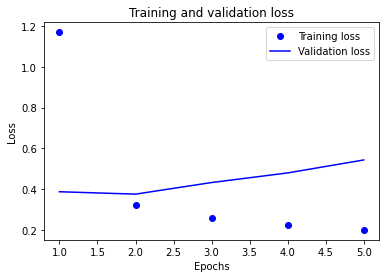

In [11]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

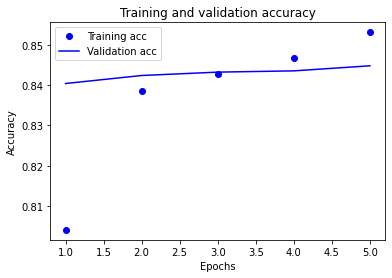

In [12]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [13]:
model.predict(np.array(["In other words #katandandre, your food was crapilicious! #mkr", "Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc"]))

array([[0.08550298],
       [0.9728286 ]], dtype=float32)

In [14]:
model.predict(np.array(["@herneythegreat http://twitpic.com/hpovu - Its sad to see that they are racist against it and saying nigger... wow... DUMB FUCKS"]))

array([[1.1878074]], dtype=float32)

In [15]:
text = input("Input a text to test the model ")
print(f"prediction for '{text}':", model.predict(np.array([text])))

prediction for 'sup': [[0.10612997]]


In [5]:
model.save('cyberbullyingClassificationModel.h5')

In [7]:
newModel = tf.keras.models.load_model('cyberbullyingClassificationModel.h5', custom_objects={'KerasLayer':hub.KerasLayer})
newModel.summary()